# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "C:/AV/Carla/CARLA_0.9.13/WindowsNoEditor/PythonAPI/experiments/logs"
dataDir = "../data/"

In [2]:
exec(open('init_notebook.py').read())

current working dirD:\AV\DataSetExploration\TTI-dataset-tools\src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
import math
from typing import *
import numpy as np

from scipy.ndimage import gaussian_filter1d

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
# Some utility tools
def makeUniqueId(recordingIds: Union[int, pd.Series], participantIds: Union[int, pd.Series]) -> int:
    return recordingIds * 1000000 + participantIds

def getRecordingPedIds(recordingMeta: Dict[str, any]) -> List[int]:
    pedIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "pedestrian":
            pedIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return pedIds


def getRecordingVehicleIds(recordingMeta: Dict[str, any]) -> List[int]:
    vIds = []
    for participant in recordingMeta["participants"]:
        if participant['class'] == "vehicle":
            vIds.append(
                makeUniqueId(recordingMeta['recordingId'], participant['id'])
            )
    return vIds

def getPedToVIds(meta: Dict[int, any]) -> Dict[int, int]:
    pToV = {}
    for recordingId, recordingMeta in meta.items():
        pedIds = getRecordingPedIds(recordingMeta)
        vIds = getRecordingVehicleIds(recordingMeta)
        for pedId in pedIds:
            pToV[pedId] = vIds.copy() # just to be safe
    return pToV
            

    
    

In [115]:
researchName = '4-lane-lc-Research1v1NavPathModel'
# researchName = '2-lane-Research1v1NavPathModel'
date = "2023-09-13"
fps=25
minYDisplacement = 5
maxXDisplacement = 9

#tracks meta
with open(os.path.join(dataDir, f"{researchName}-{date}-meta.json"), "r") as f:
    metaJson = json.load(f)

meta = {}
for recordingObj in metaJson:
    meta[recordingObj['recordingId']] = recordingObj
    

# tracks
df = pd.read_csv(os.path.join(dataDir, f"{researchName}-{date}-tracks.csv"))
df["uniqueTrackId"] = makeUniqueId(df["recordingId"], df["trackId"])
pedDf = df[df["class"] == "pedestrian"].copy()
otherDf = df[df["class"] != "pedestrian"].copy()

In [116]:
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='x', 
        yCol='y',
        xVelCol='xVel', 
        yVelCol='yVel', 
        speedCol='speed',
        fps=fps,
    )
transformer = TrajectoryTransformer(colMapper)

In [117]:
# Pre process ped
## droping unnecessary states
pedDf = pedDf[(pedDf['state'] != "INITALIZING") & (pedDf['state'] != "FINISHED") & (pedDf['state'] != "CLIMBING_SIDEWALK")].copy()
print(pedDf.tail())
transformer.deriveAxisVelocities(pedDf)
transformer.deriveSpeed(pedDf)
transformer.smoothenSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# pedDf.describe()
pedDf.head()

       recordingId  trackId       class  frame           x          y  \
75098          100     4140  pedestrian    432 -113.253433  24.085169   
75099          100     4140  pedestrian    433 -113.188370  24.131697   
75100          100     4140  pedestrian    434 -113.122871  24.181562   
75101          100     4140  pedestrian    435 -113.059059  24.230026   
75102          100     4140  pedestrian    436 -112.998581  24.275547   

         heading     state  uniqueTrackId  
75098  31.552896  CROSSING      100004140  
75099  36.135590  CROSSING      100004140  
75100  40.344212  CROSSING      100004140  
75101  36.102669  CROSSING      100004140  
75102  32.702957  CROSSING      100004140  


,recordingId,trackId,class,frame,x,y,heading,state,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
379,1,3843,pedestrian,100,-127.139915,27.763041,-14.882741,CROSSING,1003843,-1.002312,0.572491,1.154285,1.154003,0.000000,0.000000
380,1,3843,pedestrian,101,-127.099823,27.740141,-0.592804,CROSSING,1003843,-1.002312,0.572491,1.154285,1.154008,0.040092,0.022900
381,1,3843,pedestrian,102,-127.071152,27.704540,-14.992848,CROSSING,1003843,-0.716782,0.890017,1.142762,1.160292,0.068764,0.058500
382,1,3843,pedestrian,103,-127.028778,27.680075,-0.644440,CROSSING,1003843,-1.059341,0.611639,1.223236,1.183585,0.111137,0.082966
383,1,3843,pedestrian,104,-126.998482,27.642525,-15.044481,CROSSING,1003843,-0.757408,0.938749,1.206200,1.213893,0.141434,0.120516


In [118]:
# Pre-process vehicle

transformer.deriveAxisVelocities(otherDf)
transformer.deriveSpeed(otherDf)
otherDf['speed'] = otherDf['speed'] * 3.6 # to km/h
transformer.smoothenSpeed(otherDf)
transformer.deriveDisplacements(otherDf)
otherDf.describe()
# otherDf.head()

,recordingId,trackId,frame,x,y,heading,uniqueTrackId,xVel,yVel,speed,speedSmooth,displacementX,displacementY
count,37552.000000,37552.000000,37552.000000,37552.000000,37552.000000,37552.000000,3.755200e+04,37552.000000,37552.000000,37552.000000,37552.000000,37552.000000,37552.000000
mean,50.357850,3990.073551,288.673013,-115.213396,32.757405,-87.939049,5.036184e+07,-0.066687,2.787924,10.053054,10.052965,0.912831,20.739071
std,28.676017,86.028051,110.677376,0.243544,13.049038,3.916396,2.867610e+07,0.134721,0.662786,2.377795,2.362471,0.389313,12.542798
min,1.000000,3842.000000,100.000000,-116.951530,2.141091,-90.665337,1.003842e+06,-1.314926,-0.000525,0.000000,0.000000,0.000000,0.000000
25%,26.000000,3917.000000,193.000000,-115.188410,23.122068,-90.053467,2.600392e+07,-0.065231,2.266884,8.162677,8.162645,0.624451,10.059354
50%,50.000000,3989.000000,287.000000,-115.113365,33.475685,-89.588696,5.000399e+07,-0.004005,2.751327,9.906208,9.971400,0.825527,20.274414
75%,75.000000,4064.000000,381.000000,-115.097794,43.673860,-87.973654,7.500406e+07,0.004578,3.237152,11.656628,11.654490,1.192589,30.310485
max,100.000000,4139.000000,500.000000,-115.071991,56.505753,-69.513924,1.000041e+08,0.026321,5.403709,20.021019,14.619035,1.866241,48.275508


In [119]:
pedIds = pedDf["uniqueTrackId"].unique()

In [120]:
aPed = pedDf[pedDf["uniqueTrackId"] == pedIds[0]]
# plt.plot(aPed["yVel"], label='yVel')
# plt.plot(aPed["xVel"], label='xVel')
# plt.legend()
# sns.lineplot(aPed["speed"])
# sns.lineplot(aPed["speedSmooth"])

In [121]:
# smoothSpeed = aPed['speed'].rolling(10).mean()
# sns.lineplot(smoothSpeed, label='avg')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=1)
# sns.lineplot(smoothSpeed, label='gaussian1')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=2)
# sns.lineplot(smoothSpeed, label='gaussian2')
# smoothSpeed = aPed['speed'].rolling(10, win_type='gaussian').mean(std=3)
# sns.lineplot(smoothSpeed, label='gaussian3')

# Trajectory Stats & Visualizations

In [122]:
legend = False
limit = 10
plt.rcParams.update({'font.size': 24})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


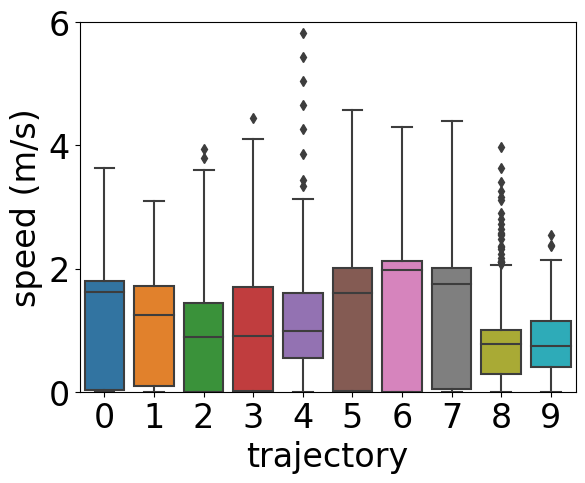

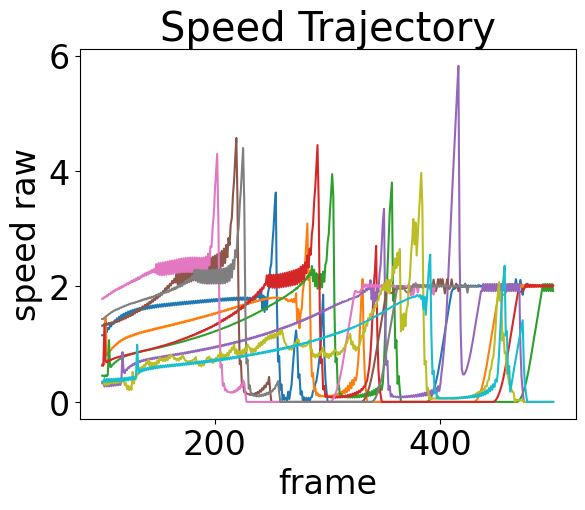

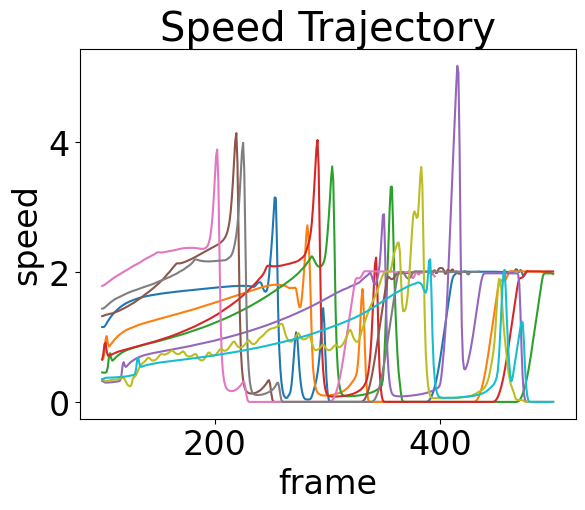

In [123]:
speedSeres = []
pedIds = pedDf["uniqueTrackId"].unique()
pedIds = pedIds[:limit]
# pedIds = np.random.choice(pedIds, limit)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    speedSeres.append(aPed["speed"])
    # print("avg speed", aPed["speed"].mean())
    # print("max speed", aPed["speed"].max())
sns.boxplot(speedSeres)
plt.ylim(0, 6)
plt.xlabel("trajectory")
plt.ylabel("speed (m/s)")
# plt.title("Speed")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

x = range(500)
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speed", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed raw")
plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed")
plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

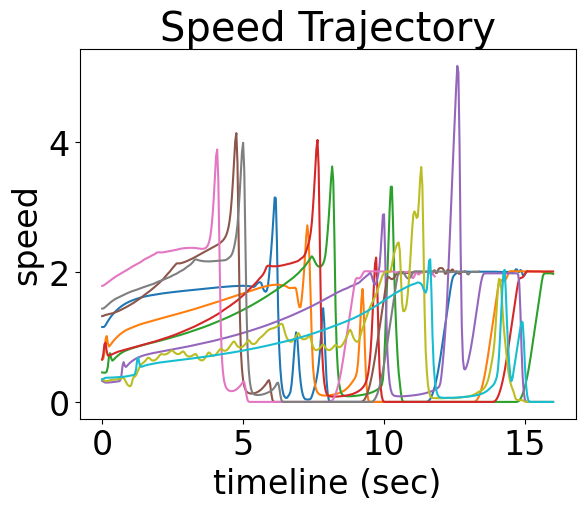

In [124]:
# visualization in seconds
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline (sec)")
plt.ylabel("speed")
plt.title("Speed Trajectory")
if not legend:
    plt.legend().remove()
else:
    plt.legend()


# Frozen State Stats and Visualization

In [126]:
frozenPedDf = pedDf[pedDf['state'] == 'FROZEN'].copy()
pedIds = frozenPedDf["uniqueTrackId"].unique()

print("Trajectories without stop", len(pedDf["uniqueTrackId"].unique()) - len(frozenPedDf["uniqueTrackId"].unique()))

limit = 10
pedIds = np.random.choice(pedIds, limit)

Trajectories without stop 1


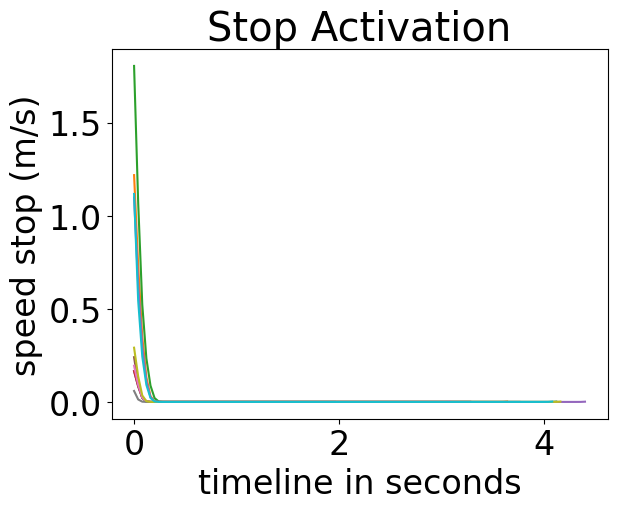

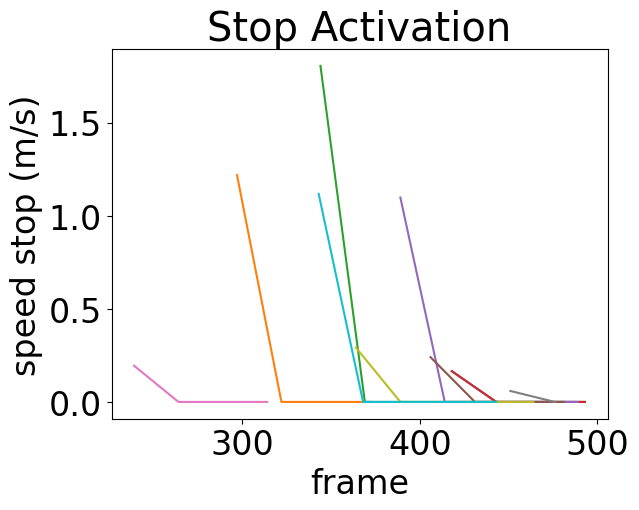

In [17]:
plt.rcParams.update({'font.size': 24})

# visualization in seconds
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("timeline in seconds")
plt.ylabel("speed stop (m/s)")
plt.title("Stop Activation")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()

# visualization in frames
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    aPed = aPed.iloc[::int(fps), :] # frame rate is 25
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}")
plt.xlabel("frame")
plt.ylabel("speed stop (m/s)")
plt.title("Stop Activation")
if not legend:
    plt.legend().remove()
else:
    plt.legend()
plt.show()



# Statistics

In [18]:
from collections import defaultdict

In [39]:
# Pedestrian statistics
pedIds = pedDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    colData['uniqueTrackId'].append(pedId)
    colData['speed-avg'].append(aPed['speed'].mean())
    colData['speed-max'].append(aPed['speed'].max())
    colData['speed-min'].append(aPed['speed'].min())
    
    ## related to stop only
    
    aPedFrozen = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    if len(aPedFrozen) > 0:
        colData['stop-duration'].append(len(aPedFrozen) / fps)
        colData['stop-loc-first-frame'].append(aPedFrozen.iloc[0]['frame'])
        colData['stop-loc-first-x'].append(aPedFrozen.iloc[0]['x'])
        colData['stop-loc-first-y'].append(aPedFrozen.iloc[0]['y'])
        colData['stop-loc-last-frame'].append(aPedFrozen.iloc[-1]['frame'])
        colData['stop-loc-last-x'].append(aPedFrozen.iloc[-1]['x'])
        colData['stop-loc-last-y'].append(aPedFrozen.iloc[-1]['y'])
        
        
    else:
        colData['stop-duration'].append(None)
        colData['stop-loc-first-frame'].append(None)
        colData['stop-loc-first-x'].append(None)
        colData['stop-loc-first-y'].append(None)
        colData['stop-loc-last-frame'].append(None)
        colData['stop-loc-last-x'].append(None)
        colData['stop-loc-last-y'].append(None)

pedStats = pd.DataFrame(colData)
pedStats.dropna(inplace=True)
pedStats.head()

,uniqueTrackId,speed-avg,speed-max,speed-min,stop-duration,stop-loc-first-frame,stop-loc-first-x,stop-loc-first-y,stop-loc-last-frame,stop-loc-last-x,stop-loc-last-y
0,1003843,1.156041,3.626612,0.0,3.68,297.0,-118.202965,21.503498,388.0,-118.179932,21.503443
1,2003846,1.007245,3.090317,0.0,3.96,332.0,-118.290443,21.564533,430.0,-118.264236,21.561371
2,3003849,0.885553,3.945541,0.0,4.20,364.0,-117.568367,21.560373,468.0,-117.568367,21.560373
3,4003852,0.964998,4.448034,0.0,4.16,344.0,-118.233315,21.643877,447.0,-118.195427,21.637608
4,5003855,1.088952,5.819839,0.0,1.24,417.0,-116.656151,21.267605,500.0,-113.892265,23.429523


In [40]:
# Vehicle statistics
vIds = otherDf["uniqueTrackId"].unique()
colData = defaultdict(lambda: list())
for vId in vIds:
    aV = otherDf[otherDf["uniqueTrackId"] == vId]
    colData['uniqueTrackId'].append(vId)
    colData['speed-avg'].append(aV['speed'].mean())
    colData['speed-max'].append(aV['speed'].max())
    colData['speed-min'].append(aV['speed'].min())
    
    
vehicleStats = pd.DataFrame(colData)
vehicleStats.tail()

,uniqueTrackId,speed-avg,speed-max,speed-min
95,96004127,13.319465,13.342306,13.270950
96,97004130,11.786734,11.894709,11.665155
97,98004133,8.068822,14.423133,6.551528
98,99004136,14.349634,14.368381,14.305850
99,100004139,12.623014,12.650754,12.564945


In [41]:
# Correlations
# plt.rcParams.update({'font.size': 24})
# sns.pairplot(pedStats[['speed-avg', 'speed-max', 'stop-duration']], height=4)

# # plt.xlabel("Correlations")
# # plt.ylabel("speed")
# # plt.title("Correlations")
# plt.show()

# Marginal Distributions

In [42]:
plt.rcParams.update({'font.size': 24})

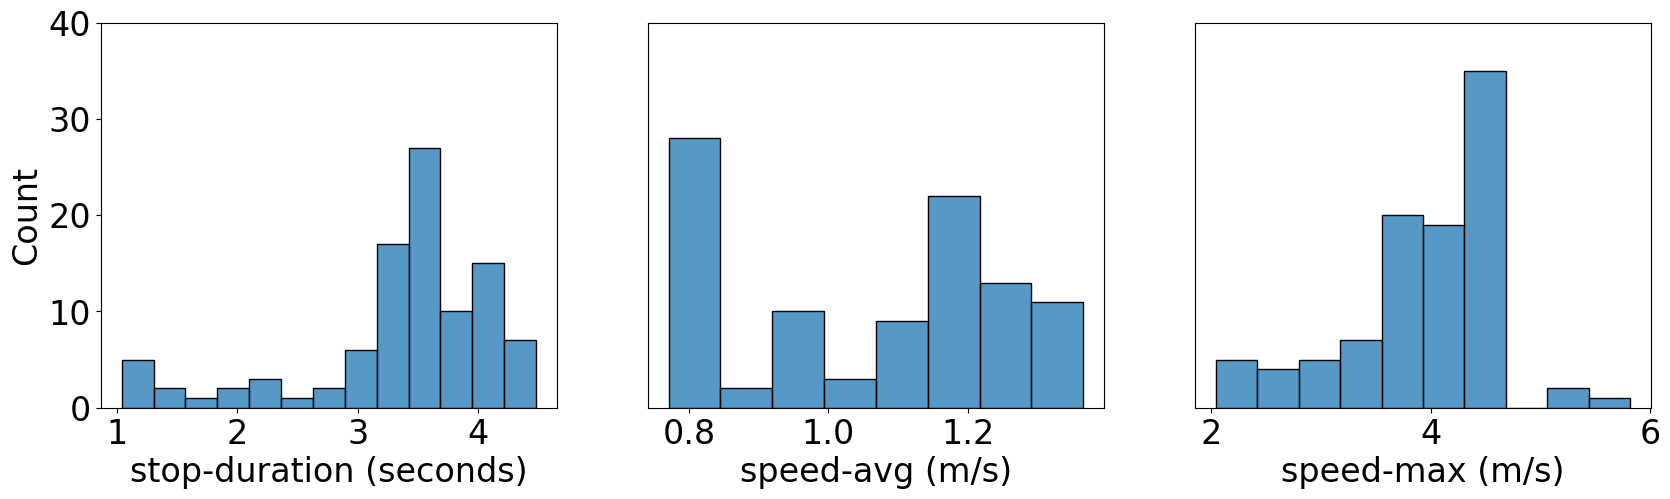

In [43]:
# Pedestrian Marginal Distributions
fig, axes = plt.subplots(1,3, figsize = (20,5))
sns.histplot(pedStats['stop-duration'] ,ax=axes[0])
axes[0].set_xlabel("stop-duration (seconds)")
axes[0].set_ylim(0, 40)

sns.histplot(pedStats['speed-avg'] ,ax=axes[1])
axes[1].set_xlabel("speed-avg (m/s)")
axes[1].set_ylim(0, 40)
axes[1].get_yaxis().set_visible(False)


sns.histplot(pedStats['speed-max'] ,ax=axes[2])
axes[2].set_xlabel("speed-max (m/s)")
axes[2].set_ylim(0, 40)
axes[2].get_yaxis().set_visible(False)



plt.show()

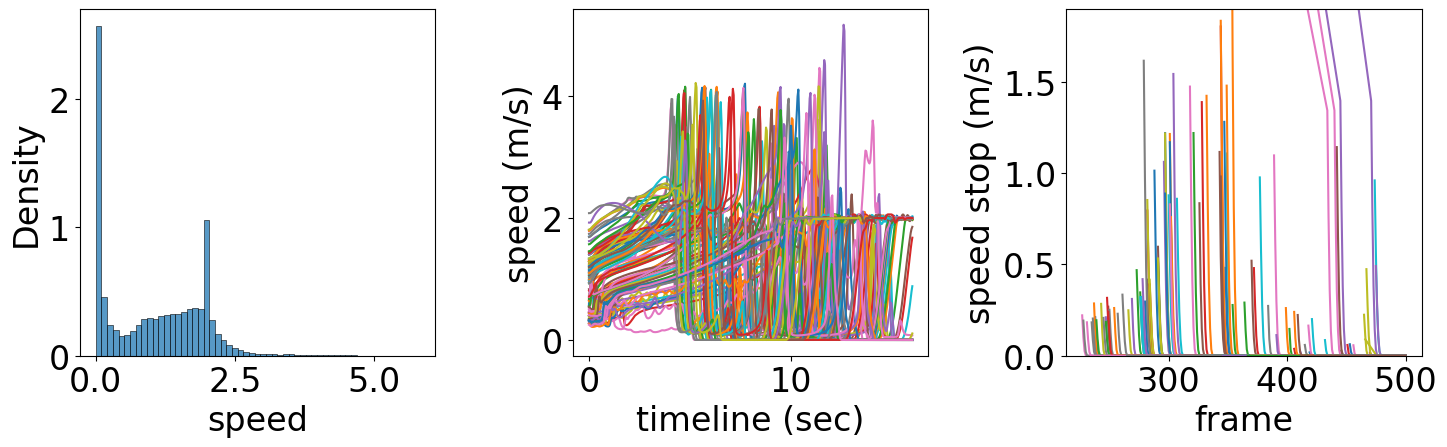

In [44]:
legend = False
fig, axes = plt.subplots(1,3, figsize = (15,5))
sns.histplot(pedDf['speed'], stat='density',ax=axes[0])
plt.xlabel("speed (m/s)")

#trajectories
for pedId in pedIds:
    aPed = pedDf[pedDf["uniqueTrackId"] == pedId]
    # aPed = aPed.iloc[::int(fps//25), :] # frame rate is 25
    # seconds = (list(range(len(aPed))) + aPed.iloc[0]["frame"] / fps)
    seconds = (aPed['frame'] - aPed.iloc[0]["frame"]) / fps
    sns.lineplot(aPed, x=seconds, y="speedSmooth", label=f"p-{pedId}", ax=axes[1])
axes[1].set_xlabel("timeline (sec)")
axes[1].set_ylabel("speed (m/s)")
if not legend:
    axes[1].legend().remove()
else:
    axes[1].legend()

# stop activation
for pedId in pedIds:
    aPed = frozenPedDf[frozenPedDf["uniqueTrackId"] == pedId]
    sns.lineplot(aPed, x='frame', y="speedSmooth", label=f"p-{pedId}", ax=axes[2])
axes[2].set_xlabel("frame")
axes[2].set_ylabel("speed stop (m/s)")
axes[2].set_ylim(0, 1.9)
if not legend:
    axes[2].legend().remove()
else:
    axes[2].legend()

fig.tight_layout()
plt.show()

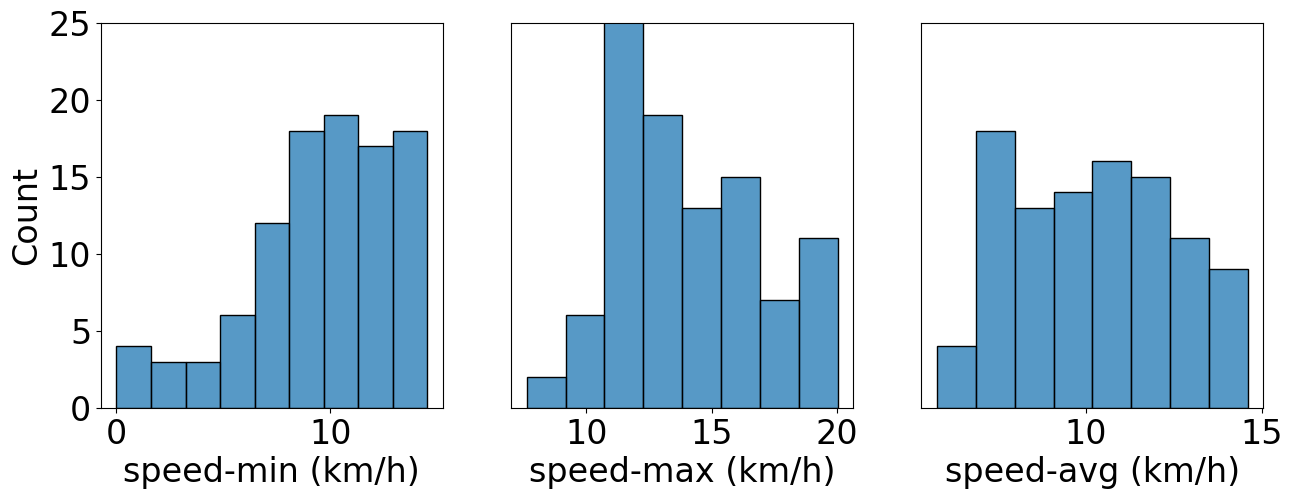

In [45]:
# Vehicle Marginal Distributions
fig, axes = plt.subplots(1, 3, figsize = (15,5))

sns.histplot(vehicleStats['speed-min'] ,ax=axes[0], label="km/h")
axes[0].set_xlabel("speed-min (km/h)")
axes[0].set_ylim(0, 25)

sns.histplot(vehicleStats['speed-max'] ,ax=axes[1])
axes[1].set_xlabel("speed-max (km/h)")
axes[1].set_ylim(0, 25)
axes[1].get_yaxis().set_visible(False)

sns.histplot(vehicleStats['speed-avg'] ,ax=axes[2])
axes[2].set_xlabel("speed-avg (km/h)")
axes[2].set_ylim(0, 25)
axes[2].get_yaxis().set_visible(False)

plt.show()

# Self joint probabilities

In [46]:
plt.rcParams.update({'font.size': 44})

In [47]:
def plotJoint(data, x, y, height=10, caxloc=[.25, .25, .02, .2], xTitle=None, yTitle=None):
    g = sns.JointGrid(data=data, x=x, y=y, height=height)
    
    # g.plot(sns.scatterplot, sns.histplot)
    cax = g.figure.add_axes(caxloc)
    # Add the joint and marginal histogram plots
    j = g.plot_joint(
        sns.histplot, discrete=(False, False),
        pmax=.8, cbar=True, cbar_ax=cax
    )
    if xTitle is None:
        xTitle = x
    if yTitle is None:
        yTitle = y
    j.set_axis_labels(xTitle, yTitle)
    # g.plot_marginals(sns.histplot, element="step", color="#03012d")
    g.plot_marginals(sns.histplot, element="step", color="#ccdddd",)
    

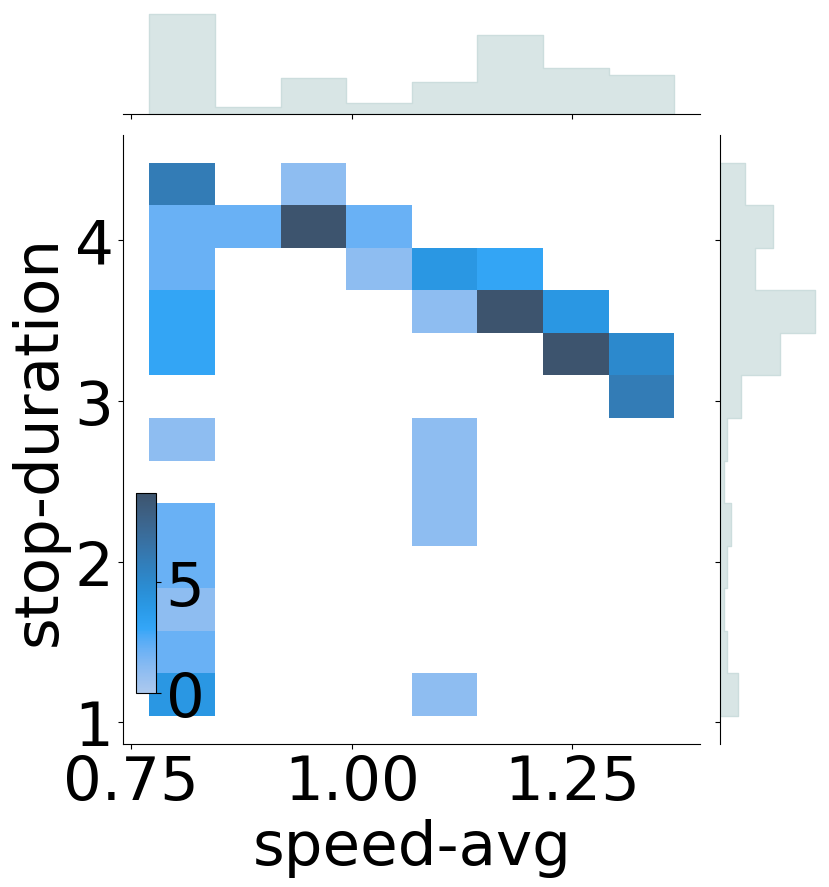

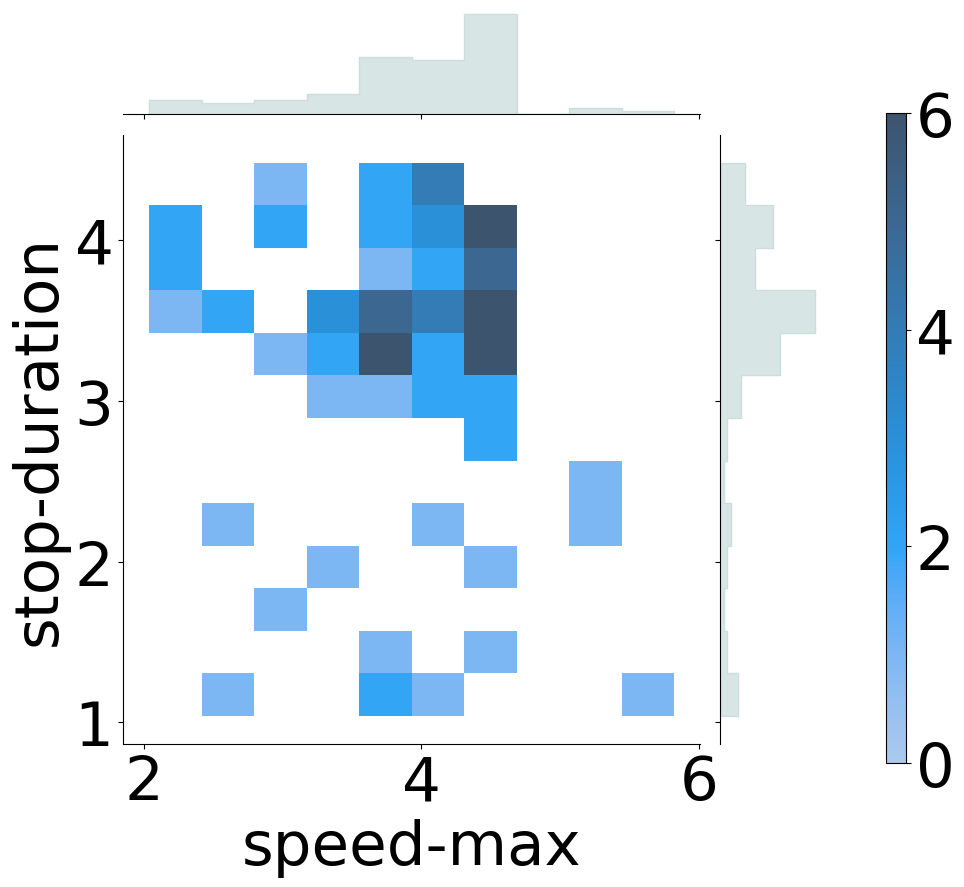

In [48]:

# g = sns.JointGrid(data=pedStats, x="speed-avg", y="stop-duration", height=10)
# # g.plot(sns.scatterplot, sns.histplot)

# cax = g.figure.add_axes([.15, .15, .02, .2])
# # Add the joint and marginal histogram plots
# j = g.plot_joint(
#     sns.histplot, discrete=(False, False),
#     cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
# )
# g.plot_marginals(sns.histplot, element="step", color="#03012d")

plotJoint(data=pedStats, x="speed-avg", y="stop-duration", height=10)
plotJoint(data=pedStats, x="speed-max", y="stop-duration", height=10, caxloc=[1.0, .18, .02, .65])


In [49]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="hist", height=10)
# ax = g.ax_joint
# cbar_ax = kdeplot.fig.add_axes([.85, .25, .05, .4])
# # plt.colorbar(ax=ax, cax=cbar_ax)
# # plt.show()
# PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
# print(PCM)
# plt.colorbar(PCM, ax=ax, cax=cbar_ax) 


In [50]:
# g = sns.jointplot(x=pedStats['speed-avg'], y=pedStats['stop-duration'], kind="kde", height=10)

In [51]:
# g = sns.jointplot(x=pedStats['speed-max'], y=pedStats['stop-duration'], kind="kde", height=10)

# Vehicle joint plots

In [74]:
# 1. create ped vehicle map

# mapping
pedToVehicle = getPedToVIds(meta)
# print(pedToVehicle)

# combine stats
# each ped row has a combination with each associated vehicle
pedCols = ['uniqueTrackId', 'stop-duration', 'speed-avg']
vehCols = ['uniqueTrackId', 'speed-avg']

newCols = ['pId', 'p-stop-duration', 'p-speed-avg', 'vId', 'v-speed-avg', 'stop-distance', 'stop-time', 'v-speed-stop']
pedIds = pedStats['uniqueTrackId'].unique()
vIds = vehicleStats['uniqueTrackId'].unique()
jointRows = []
for pedId in pedIds:
    aPed = pedStats[pedStats["uniqueTrackId"] == pedId]
    
    stopFrame = aPed.iloc[0]['stop-loc-first-frame']
    # if np.isnan(stopFrame):
    #     continue
    stopX, stopY = aPed.iloc[0]['stop-loc-first-x'], aPed.iloc[0]['stop-loc-first-y']
    
    aPed = aPed[pedCols].copy() # selection
    aPed["uniqueTrackId"] = aPed["uniqueTrackId"].astype(int)
    vIds = pedToVehicle[pedId]
    for vId in vIds:
        aV = vehicleStats[vehicleStats["uniqueTrackId"] == vId]
        aVTraj = otherDf[otherDf["uniqueTrackId"] == vId]
        
        # statistics when the pedestrian made the stop
        # print(stopFrame)
        # print(aVTraj['frame'])
        avPedStopFrameDf = aVTraj[aVTraj["frame"] == stopFrame]
        vStopX, vStopY = avPedStopFrameDf.iloc[0]['x'], avPedStopFrameDf.iloc[0]['y']
        vSpeed = avPedStopFrameDf.iloc[0]['speedSmooth']
        
        aV = aV[vehCols].copy() # selection
        aV['stop-distance'] = math.sqrt((stopX - vStopX) ** 2 + (stopY - vStopY) ** 2)
        aV['stop-time'] = stopFrame // fps
        aV['v-speed-stop'] = vSpeed
        
        aPed.reset_index(drop=True, inplace=True)
        aV.reset_index(drop=True, inplace=True)
        row = pd.concat([aPed, aV], axis=1, ignore_index=True)
        # if pedId == 35003945:
        #     print("ped", aPed)
        #     print("av", aV)
        #     print("combined", row)
        jointRows.append(row)
        
        break # get only one

# print(pedStats[pedStats["uniqueTrackId"] == 35003945])
# print(len(jointRows))
# print(jointRows)

jointStats = pd.concat(jointRows, ignore_index=True)
jointStats.columns = newCols

# print(len(pedStats), len(jointStats), len(jointStats["vId"].unique()))

assert len(pedStats) == len(jointStats)

# jointStats.describe()
# jointStats[0]
jointStats.tail()

,pId,p-stop-duration,p-speed-avg,vId,v-speed-avg,stop-distance,stop-time,v-speed-stop
93,96004128,3.20,1.284503,96004127,13.319465,8.312571,9.0,13.320262
94,97004131,3.52,1.204735,97004130,11.786734,7.863940,11.0,11.723627
95,98004134,3.68,0.779621,98004133,8.068822,6.703973,16.0,8.123768
96,99004137,3.08,1.340054,99004136,14.349634,8.555929,9.0,14.350158
97,100004140,3.36,1.247902,100004139,12.623014,8.183913,10.0,12.619731


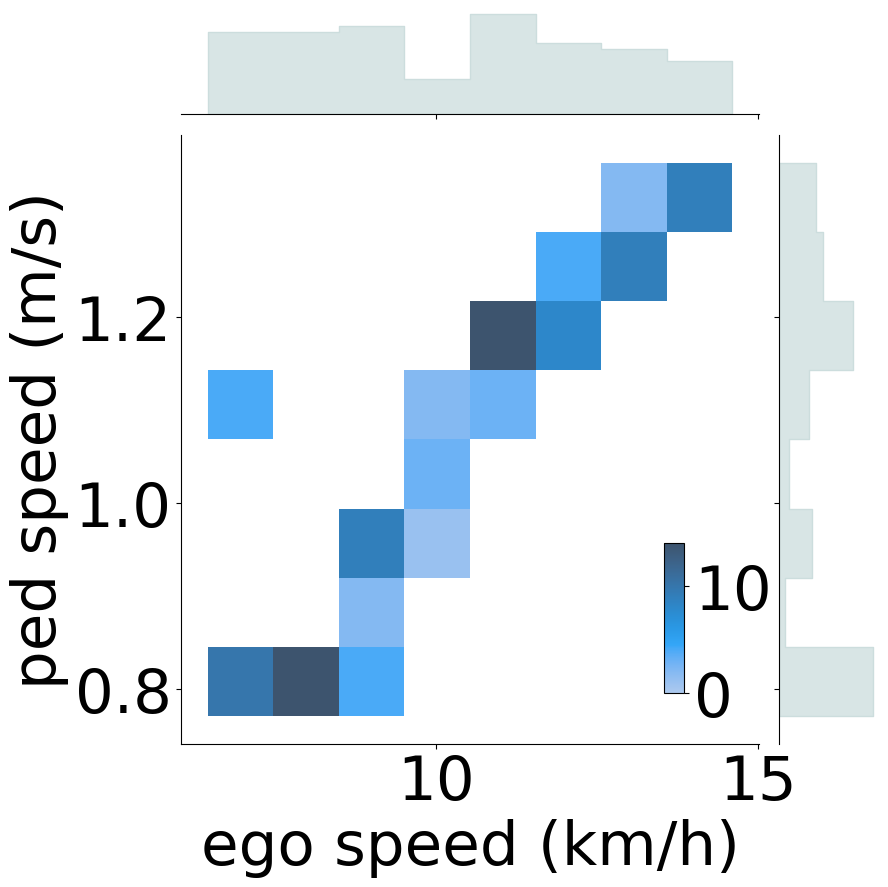

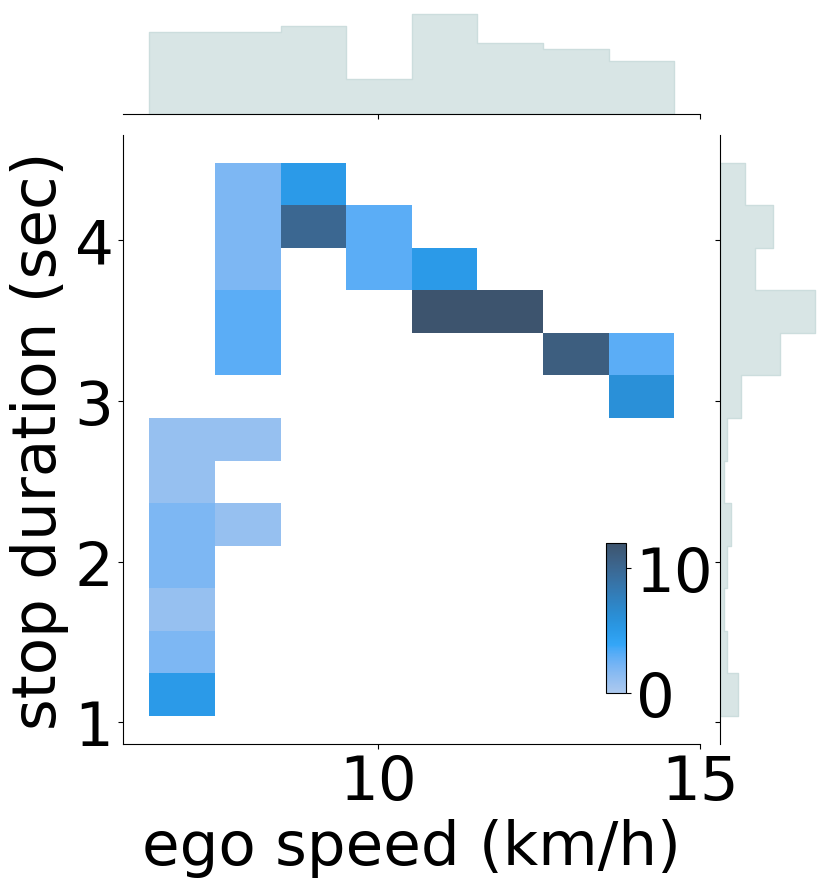

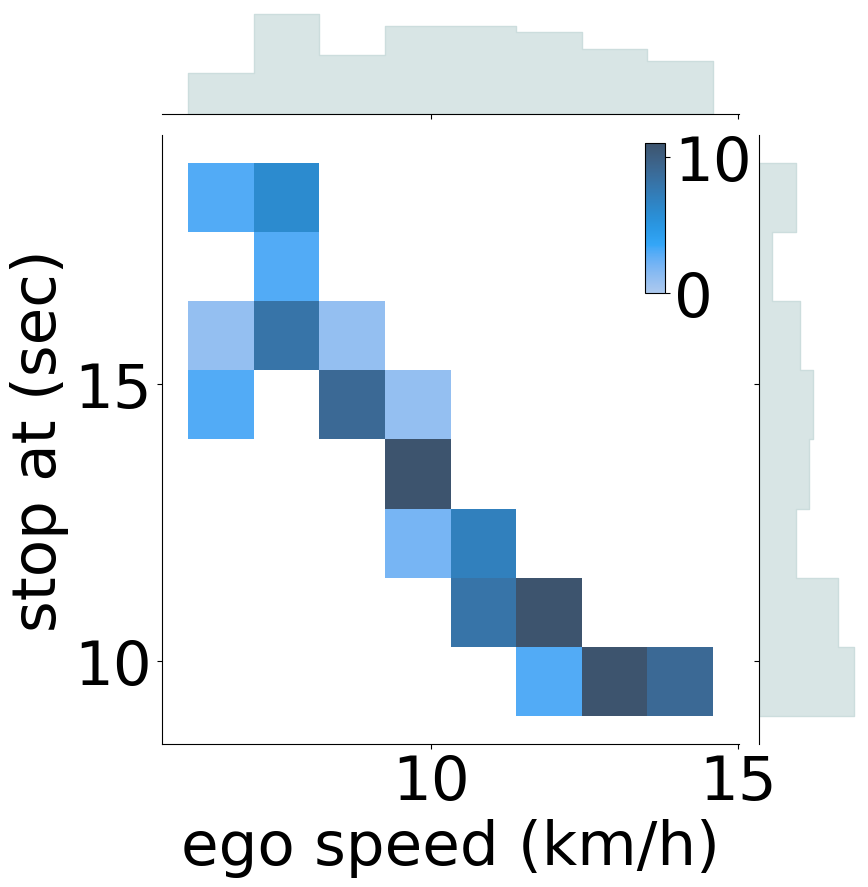

In [75]:
# 2. vehicle speed vs ped speed
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="p-speed-avg", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="ped speed (m/s)",
    caxloc=[0.72, .25, 0.02, .15]
)
# 3. vehicle speed vs ped stop duration
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="p-stop-duration", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop duration (sec)",
    caxloc=[0.72, .25, 0.02, .15]
)

# 3. vehicle actual speed vs ped stop time
plotJoint(
    data=jointStats, 
    x="v-speed-stop", 
    y="stop-time", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop at (sec)",
    caxloc=[0.72, .65, 0.02, .15]
)

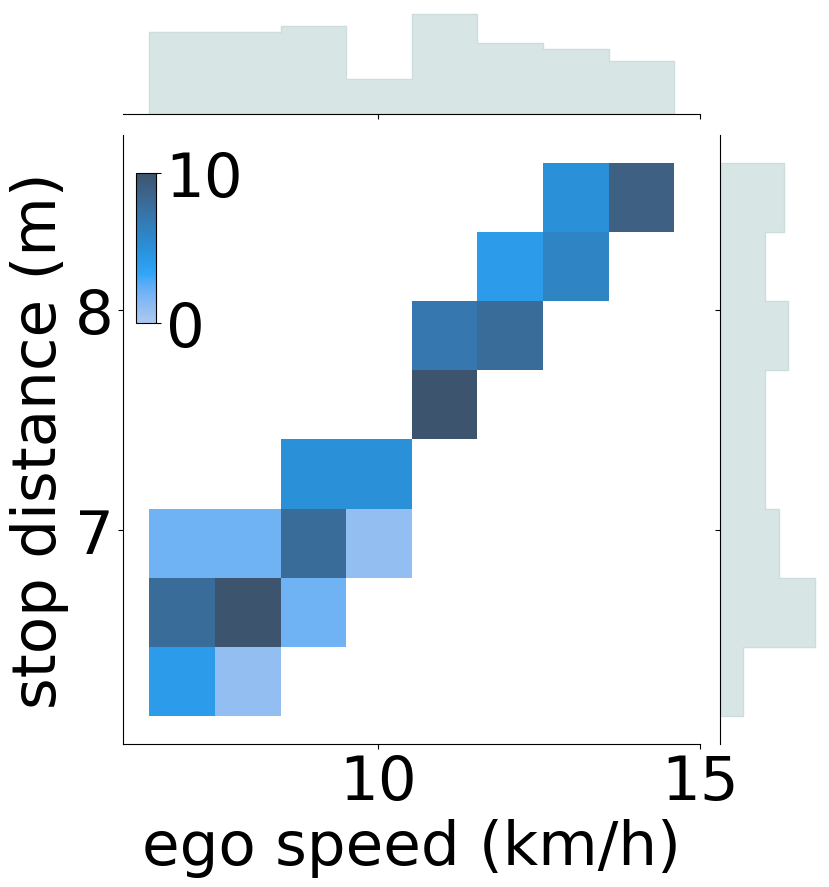

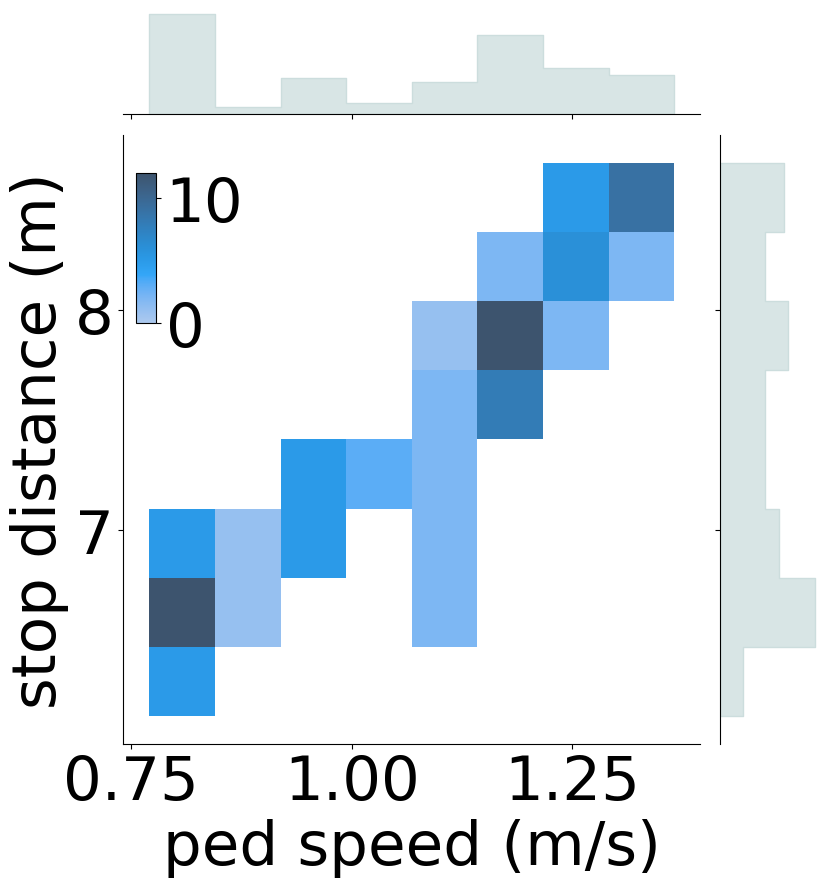

In [76]:
# 4. vehicle speed vs ped stop location
plotJoint(
    data=jointStats, 
    x="v-speed-avg", 
    y="stop-distance", 
    height=10, 
    xTitle="ego speed (km/h)", 
    yTitle="stop distance (m)",
    caxloc=[0.25, .62, 0.02, .15]
)


# 4. ped speed vs ped stop location
plotJoint(
    data=jointStats, 
    x="p-speed-avg", 
    y="stop-distance", 
    height=10, 
    xTitle="ped speed (m/s)", 
    yTitle="stop distance (m)",
    caxloc=[0.25, .62, 0.02, .15]
)

